In [1]:
#Importing the libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import torch
import torch.nn as nn
import torch.nn.functional as F

from Signal_Analyzer import  *

import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

In [2]:
class ConditionalInstanceNorm1d(nn.Module):
    def __init__(self, num_features, num_conditions):
        super(ConditionalInstanceNorm1d, self).__init__()
        self.num_features = num_features
        self.inst_norm = nn.InstanceNorm1d(num_features, affine=False)
        self.embed = nn.Linear(num_conditions, num_features * 2)

    def forward(self, x, condition):
        out = self.inst_norm(x)
        alpha, beta = self.embed(condition).chunk(2, dim=1)
        alpha = alpha.unsqueeze(2).expand_as(out)
        beta = beta.unsqueeze(2).expand_as(out)
        return alpha * out + beta

In [3]:
class UNetGenerator(nn.Module):
    def __init__(self, in_channels, out_channels, hidden_channels=64, num_conditions=3):
        super(UNetGenerator, self).__init__()
        self.down1 = nn.Sequential(
            nn.Conv1d(in_channels, hidden_channels, kernel_size=4, stride=2, padding=1),
            nn.ReLU(inplace=True)
        )
        self.cin1 = ConditionalInstanceNorm1d(hidden_channels, num_conditions)
        self.down2 = nn.Sequential(
            nn.Conv1d(hidden_channels, hidden_channels * 2, kernel_size=4, stride=2, padding=1),
            nn.ReLU(inplace=True)
        )
        self.cin2 = ConditionalInstanceNorm1d(hidden_channels * 2, num_conditions)
        self.up1 = nn.Sequential(
            nn.ConvTranspose1d(hidden_channels * 2, hidden_channels, kernel_size=4, stride=2, padding=1),
            nn.ReLU(inplace=True)
        )
        self.cin3 = ConditionalInstanceNorm1d(hidden_channels, num_conditions)
        self.up2 = nn.Sequential(
            nn.ConvTranspose1d(hidden_channels * 2, out_channels, kernel_size=4, stride=2, padding=1),
            nn.Tanh()
        )

    def forward(self, x, condition):
        d1 = self.down1(x)
        d1_norm = self.cin1(d1, condition)
        d2 = self.down2(d1_norm)
        d2_norm = self.cin2(d2, condition)
        u1 = self.up1(d2_norm)
        u1_norm = self.cin3(u1, condition)
        output = self.up2(torch.cat([u1_norm, d1_norm], dim=1))
        return output

In [4]:
t = np.linspace(0, 1, 1000)
A = 1.0  # Amplitude
omega = 2 * np.pi  # Frequency, 2π for a 1 Hz sine wave
theta = 0.0  # Phase

# Condition vector [A, omega, theta]
condition = torch.tensor([A, omega, theta], dtype=torch.float32).unsqueeze(0)

# Input noise (not used for sine wave generation but required by the network architecture)
input_noise = torch.randn(1, 1, 1000)

# Initialize the generator
generator = UNetGenerator(in_channels=1, out_channels=1)

# Generate the signal again with the corrected generator
with torch.no_grad():
    generated_signal = generator(input_noise, condition).squeeze().numpy()

In [5]:
len(generated_signal)

1000

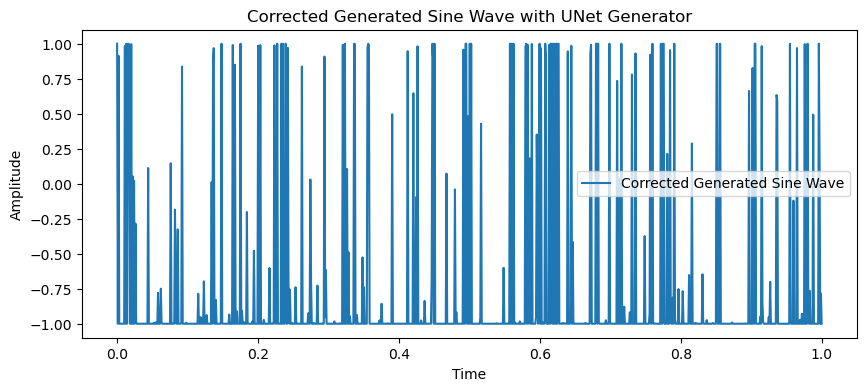

In [6]:
# Plot the corrected generated signal
plt.figure(figsize=(10, 4))
plt.plot(t, generated_signal, label='Corrected Generated Sine Wave')
plt.title('Corrected Generated Sine Wave with UNet Generator')
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.legend()
plt.show()